# Load the data

In [1]:
import pandas as pd
from src.data.data import remove_fake_reps, retrieve_variables, combine_variables
from src.features.features import aggregate_vars

path_to_data = '/home/hyruuk/GitHub/neuromod/hyruuk_shinobi_behav/data'

Two ways to go : 
- Make sure that the data are in path_to_data following either bids (home) or pseudo-bids (scans) convention. This is done by running the next cell.
- Download the file at --ask me for link-- and open it with the following cell

In [2]:


# load the data in a dict structure
alldata_dict = {}
for subject in ['sub-01', 'sub-02']:
    for level in ['1', '4', '5']:
        for setup in ['home', 'scan']:
            if setup == 'home':
                behav = True
            if setup == 'scan':
                behav = False
            allvars = combine_variables(path_to_data, subject, level, behav=behav, save=True)
            allvars_clean = remove_fake_reps(allvars)
            data_dict = aggregate_vars(allvars, metric=None, days_of_train=False, health_lost=True, max_score=True, completion_perc=True)
            alldata_dict['{}_{}_{}'.format(subject, level, setup)] = data_dict
            

# arrange the data as a dataframe suited for stats
df = pd.DataFrame(columns=['Passage order', 'Health loss', 'Max score', 'Percent complete', 'Subject', 'Level', 'Setup'])
for key in alldata_dict.keys():
    for idx in alldata_dict[key][list(alldata_dict[key].keys())[0]]:
        df = df.append({
         "Passage order": alldata_dict[key]['Passage order'][idx],
         "Health loss":  alldata_dict[key]['Health loss'][idx],
         "Max score": alldata_dict[key]['Max score'][idx],
         "Percent complete": alldata_dict[key]['Percent complete'][idx],
         "Subject": key[5],
         "Level": key[7],
         "Setup": key[9:13]
          }, ignore_index=True)

df.reset_index().to_csv(path_to_data + '/processed/homeVSscan.csv')

FileNotFoundError: [Errno 2] No such file or directory: '/home/hyruuk/GitHub/neuromod/hyruuk_shinobi_behav/data/bidsbehav/sub-01'

In [3]:
df = pd.read_csv(path_to_data + '/processed/homeVSscan.csv')

# Now let's run some stats

We want to run an ANOVA on each measure with the factors "Setup" (home vs scan), "Subject" (1 vs 2, maybe more later), "Level" (1 vs 4 vs 5), and we would like to see the Setup factor as non-significant.

Let's start with a quick seaborn plot of the data.

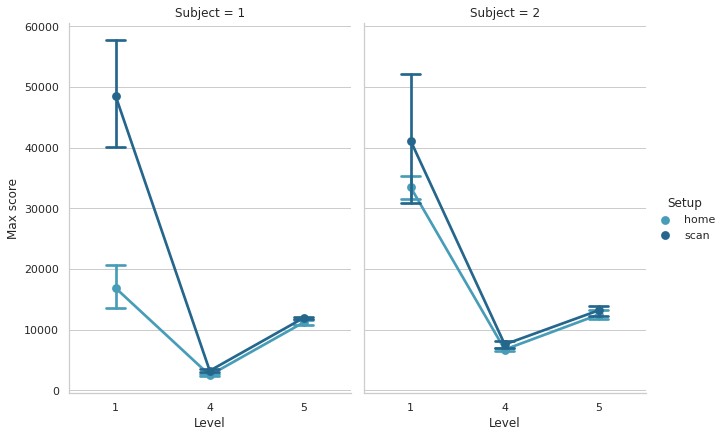

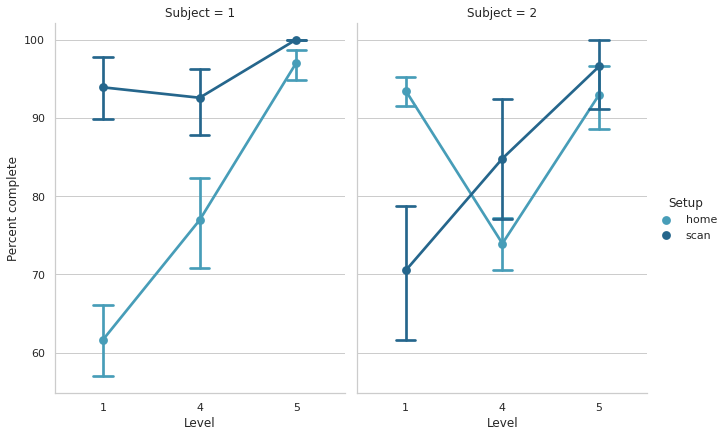

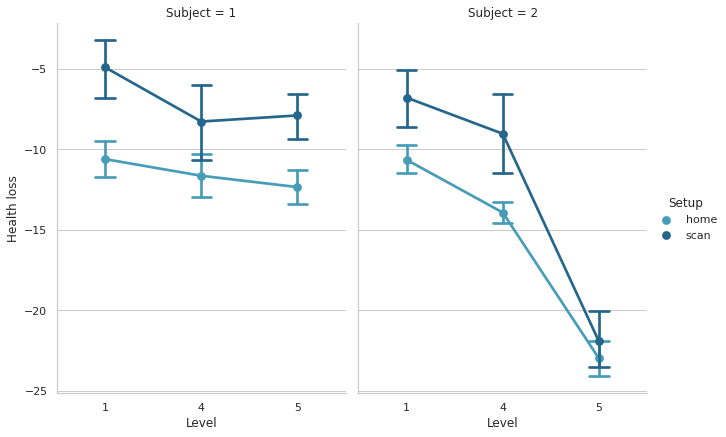

In [6]:
import seaborn as sns
sns.set_theme(style="whitegrid")

# Load the example exercise dataset
#df = sns.load_dataset("exercise")

# Draw a pointplot to show pulse as a function of three categorical factors
g = sns.catplot(x="Level", y="Max score", hue="Setup", col="Subject",
                capsize=.2, palette="YlGnBu_d", height=6, aspect=.75,
                kind="point", data=df)
g = sns.catplot(x="Level", y="Percent complete", hue="Setup", col="Subject",
                capsize=.2, palette="YlGnBu_d", height=6, aspect=.75,
                kind="point", data=df)
g = sns.catplot(x="Level", y="Health loss", hue="Setup", col="Subject",
                capsize=.2, palette="YlGnBu_d", height=6, aspect=.75,
                kind="point", data=df)
#g.despine(left=True)

Pretty good. It shouldn't be too hard to show that scan sessions were not worse than home sessions.  
Before going further we're gonna need to dummy code our level variable, rescale all the others, and clean the df.

In [87]:
df = pd.read_csv(path_to_data + '/processed/homeVSscan.csv')


# Start by transforming the setup variable into an int
def setup_to_numeric(x):
    if x == 'home':
        return 0
    if x == 'scan':
        return 1

df['Setup'] = df['Setup'].apply(setup_to_numeric) # transform setup into a binary variable
df = pd.concat([df,pd.get_dummies(df['Level'])],axis=1) # dummy codes for Level
df['Subject'] = df['Subject'].apply(lambda x: x-1) # adjust subject id
# rescale features
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
num_vars = ['Health loss', 'Max score', 'Percent complete']
df[num_vars] = scaler.fit_transform(df[num_vars])
df = df.drop(['Passage order', 'index', 'Unnamed: 0', 'Level'], axis=1) # drop the junk
df.pop(5)
df

,Health loss,Max score,Percent complete,Subject,Setup,1,4
0,0.46875,0.046019,0.479916,0,0,1,0
1,0.50000,0.028429,0.309116,0,0,1,0
2,0.37500,0.052272,0.479916,0,0,1,0
3,0.37500,0.043351,0.441408,0,0,1,0
4,0.50000,0.029262,0.292787,0,0,1,0
...,...,...,...,...,...,...,...
1254,0.18750,0.121301,1.000000,1,1,0,0
1255,0.18750,0.114548,1.000000,1,1,0,0
1256,0.31250,0.112213,1.000000,1,1,0,0
1257,0.34375,0.114798,1.000000,1,1,0,0


In [88]:
y = df.pop('Max score')
df.pop('Health loss')
df.pop('Percent complete')
df.pop('Setup')
X = df

In [89]:
X, y

(      Subject  1  4
 0           0  1  0
 1           0  1  0
 2           0  1  0
 3           0  1  0
 4           0  1  0
 ...       ... .. ..
 1254        1  0  0
 1255        1  0  0
 1256        1  0  0
 1257        1  0  0
 1258        1  0  0
 
 [1259 rows x 3 columns],
 0       0.046019
 1       0.028429
 2       0.052272
 3       0.043351
 4       0.029262
           ...   
 1254    0.121301
 1255    0.114548
 1256    0.112213
 1257    0.114798
 1258    0.114714
 Name: Max score, Length: 1259, dtype: float64)

In [90]:
import statsmodels.api as sm
X_lm = sm.add_constant(X)

lr = sm.OLS(y, X_lm).fit()

lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Max score   R-squared:                       0.318
Model:                            OLS   Adj. R-squared:                  0.317
Method:                 Least Squares   F-statistic:                     195.3
Date:                Thu, 28 Jan 2021   Prob (F-statistic):          6.00e-104
Time:                        00:06:42   Log-Likelihood:                 616.60
No. Observations:                1259   AIC:                            -1225.
Df Residuals:                    1255   BIC:                            -1205.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0784      0.010      7.744      0.000       0.059       0.098
Subject        0.0518      0.009      5.935      0.000       0.035       0.069
1              0.1469      0.012     12.553      0.000       0.124       0.170
4             -0.0699      0.012     -5.756      0.000      -0.094      -0.046
==============================================================================
Omnibus:                      734.152   Durbin-Watson:                   1.326
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             8184.919
Skew:                           2.516   Prob(JB):                         0.00
Kurtosis:                      14.433   Cond. No.                         5.58
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Now let's see with regressions

In [40]:
print(df.describe())

       Health loss    Max score  Percent complete      Subject        Setup  \
count  1259.000000  1259.000000       1259.000000  1259.000000  1259.000000   
mean      0.631727     0.146634          0.816967     0.584591     0.213662   
std       0.235805     0.179658          0.284952     0.492988     0.410054   
min       0.000000     0.000000          0.000000     0.000000     0.000000   
25%       0.500000     0.038433          0.736072     0.000000     0.000000   
50%       0.500000     0.071280          0.996782     1.000000     0.000000   
75%       0.875000     0.230179          1.000000     1.000000     0.000000   
max       1.000000     1.000000          1.000000     1.000000     1.000000   

                 1            4            5  
count  1259.000000  1259.000000  1259.000000  
mean      0.436060     0.374901     0.189039  
std       0.496092     0.484290     0.391695  
min       0.000000     0.000000     0.000000  
25%       0.000000     0.000000     0.000000  
50%   

In [86]:
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Max score   R-squared:                       0.345
Model:                            OLS   Adj. R-squared:                  0.343
Method:                 Least Squares   F-statistic:                     165.0
Date:                Thu, 28 Jan 2021   Prob (F-statistic):          1.63e-113
Time:                        00:05:13   Log-Likelihood:                 641.52
No. Observations:                1259   AIC:                            -1273.
Df Residuals:                    1254   BIC:                            -1247.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0555      0.010      5.315      0.000       0.035       0.076
Subject        0.0559      0.009      6.511      0.000       0.039       0.073
Setup          0.0720      0.010      7.117      0.000       0.052       0.092
1              0.1515      0.011     13.173      0.000       0.129       0.174
4             -0.0613      0.012     -5.123      0.000      -0.085      -0.038
==============================================================================
Omnibus:                      649.125   Durbin-Watson:                   1.380
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6226.458
Skew:                           2.188   Prob(JB):                         0.00
Kurtosis:                      12.977   Cond. No.                         5.76
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Deprecated

In [35]:
### ANOVAS

# reload the df in case
df = pd.read_csv(path_to_data + '/processed/homeVSscan.csv')
# Start by transforming the setup variable into an int
def setup_to_numeric(x):
    if x == 'home':
        return 0
    if x == 'scan':
        return 1

df['Setup'] = df['Setup'].apply(setup_to_numeric) # transform setup into a binary variable

# Run the ANOVA
from statsmodels.stats.anova import AnovaRM



aovrm2way = AnovaRM(df, 'Max score', 'Subject', within=['Setup', 'Level'], aggregate_func='mean')
res2way = aovrm2way.fit()
print(res2way)

aovrm2way = AnovaRM(df, 'Health loss', 'Subject', within=['Setup', 'Level'], aggregate_func='mean')
res2way = aovrm2way.fit()
print(res2way)

aovrm2way = AnovaRM(df, 'Percent complete', 'Subject', within=['Setup', 'Level'], aggregate_func='mean')
res2way = aovrm2way.fit()
print(res2way)

                  Anova
            F Value  Num DF Den DF Pr > F
-----------------------------------------
Setup         3.1358 1.0000 1.0000 0.3273
Level       284.4035 2.0000 2.0000 0.0035
Setup:Level   2.4764 2.0000 2.0000 0.2877

                 Anova
            F Value Num DF Den DF Pr > F
----------------------------------------
Setup       39.5662 1.0000 1.0000 0.1004
Level        1.6540 2.0000 2.0000 0.3768
Setup:Level  0.6772 2.0000 2.0000 0.5962

                 Anova
            F Value Num DF Den DF Pr > F
----------------------------------------
Setup        0.5112 1.0000 1.0000 0.6049
Level       12.5927 2.0000 2.0000 0.0736
Setup:Level  0.1227 2.0000 2.0000 0.8907

